In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import shutil
from matplotlib import pyplot
import numpy as np
import pywt
import cv2 
import pandas as pd  

# New Section

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/monkey dataset')

In [ ]:
os.getcwd()

'/content/gdrive/MyDrive/Colab Notebooks/monkey dataset'

In [ ]:
face_cascade = cv2.CascadeClassifier('./opencv//haarcascade//haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascade/haarcascade_eye.xml')

In [ ]:
def get_cropped_img_with_eyes(img_path):
    img = cv2.imread(img_path)
    if img is not None:
        gr = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray = cv2.convertScaleAbs(gr)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        for (x,y,w,h) in faces:
            roi_gray = gray[y:y+h, x:x+w]
            roi_color = img[y:y+h, x:x+w]
            eyes = eye_cascade.detectMultiScale(roi_gray)
            if len(eyes) >= 2:
                return roi_color

In [ ]:
path_to_data = "./dataset/"
path_to_cr_data = "./dataset/cropped/"

In [ ]:
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [ ]:
img_dirs

['./dataset/Prof. snape',
 './dataset/Hermione Granger',
 './dataset/Harry Potter',
 './dataset/Ron Weasley',
 './dataset/Voldermort']

In [ ]:
if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [ ]:
cropped_folder = path_to_cr_data + character_name

In [ ]:
cropped_image_dir =[]
character_name_dict ={}


for img_dir in img_dirs:
    character_name = img_dir.split('/')[-1]
    print(character_name)
    count = 1
    character_name_dict[character_name] = []
    
    
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_img_with_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + character_name         
            if not os.path.exists(cropped_folder):
                os.mkdir(cropped_folder)
                cropped_image_dir.append(cropped_folder)
                print('generating cropped images',cropped_folder)
                
        cropped_file_name = character_name + str(count) + ".png"
        cropped_file_path = cropped_folder + "/" + cropped_file_name
        if roi_color is not None:
            cv2.imwrite(cropped_file_path, roi_color)
        
        character_name_dict[character_name].append(cropped_file_path)
        count+=1
        

Prof. snape
generating cropped images ./dataset/cropped/Prof. snape
Hermione Granger
generating cropped images ./dataset/cropped/Hermione Granger
Harry Potter
generating cropped images ./dataset/cropped/Harry Potter
Ron Weasley
generating cropped images ./dataset/cropped/Ron Weasley
Voldermort
generating cropped images ./dataset/cropped/Voldermort


In [ ]:
def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H



In [ ]:
class_dict = {}
count = 0
for character_name in character_name_dict.keys():
    class_dict[character_name] = count
    count = count + 1
class_dict

{'Harry Potter': 2,
 'Hermione Granger': 1,
 'Prof. snape': 0,
 'Ron Weasley': 3,
 'Voldermort': 4}

In [ ]:
for character_name in class_dict:
  print(class_dict[character_name])

0
1
2
3
4


In [ ]:
X, y = [], []
for character_name, training_files in character_name_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        if img is None:
          continue
        scaled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scaled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scaled_raw_img.reshape(32*32*3,1),scaled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[character_name]) 

In [ ]:
len(X)

464

In [ ]:
len(X[0])

4096

In [ ]:
X.shape

(464, 4096)

In [ ]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(464, 4096)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, stratify = y)

In [ ]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [0.1, 1, 10, 100, 1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10,15,25,50,100]
        }
    }
}


In [ ]:
scores = []
best_estimators = {}

for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df



,model,best_score,best_params
0,svm,0.859089,"{'svc__C': 0.1, 'svc__kernel': 'linear'}"
1,random_forest,0.761408,{'randomforestclassifier__n_estimators': 100}


In [ ]:
best_estimators



{'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier', RandomForestClassifier())]),
 'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=0.1, gamma='auto', kernel='linear', probability=True))])}

In [ ]:
best_estimators['svm'].score(X_test,y_test)

0.8362068965517241

In [ ]:
best_estimators['random_forest'].score(X_test,y_test)

0.7413793103448276

In [ ]:
best_clf = best_estimators['svm']

In [ ]:
best_model = Pipeline(steps=[('standardscaler', StandardScaler()),('svc', SVC(C=0.1, gamma='auto', kernel='linear', probability=True))])
best_model.fit(X_train, y_train)
best_model.score(X_test, y_test)

0.8362068965517241

In [ ]:
confusion_m = confusion_matrix(y_test, best_model.predict(X_test))

Text(69.0, 0.5, 'Truth')

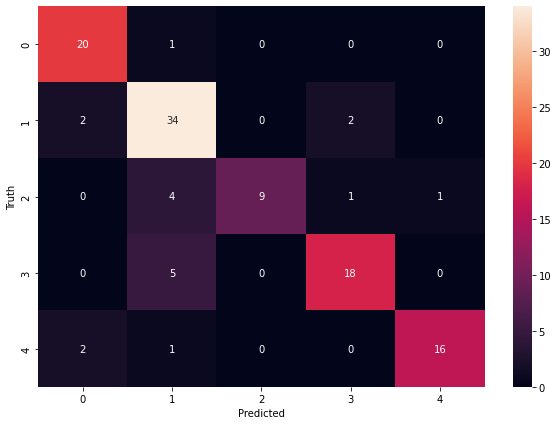

In [ ]:
plt.figure(figsize = (10,7))
sns.heatmap(confusion_m, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
import pickle

In [ ]:
with open('model_pkl', 'wb') as files:
    pickle.dump(best_model, files)

In [ ]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))